In [23]:
import pandas as pd
import numpy as np

from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import FeatureUnion, _fit_transform_one, _transform_one
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_recall_curve
from sklearn.preprocessing import StandardScaler
from joblib import Parallel, delayed
from scipy import sparse

In [24]:
# https://www.kaggle.com/teejmahal20/airline-passenger-satisfaction
df_train = pd.read_csv("./AirlinePassengerSatisfaction/train.csv")
df_test = pd.read_csv("./AirlinePassengerSatisfaction/test.csv")

In [25]:
df_train.head()

,Unnamed: 0,id,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,...,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
0,0,70172,Male,Loyal Customer,13,Personal Travel,Eco Plus,460,3,4,...,5,4,3,4,4,5,5,25,18.0,neutral or dissatisfied
1,1,5047,Male,disloyal Customer,25,Business travel,Business,235,3,2,...,1,1,5,3,1,4,1,1,6.0,neutral or dissatisfied
2,2,110028,Female,Loyal Customer,26,Business travel,Business,1142,2,2,...,5,4,3,4,4,4,5,0,0.0,satisfied
3,3,24026,Female,Loyal Customer,25,Business travel,Business,562,2,5,...,2,2,5,3,1,4,2,11,9.0,neutral or dissatisfied
4,4,119299,Male,Loyal Customer,61,Business travel,Business,214,3,3,...,3,3,4,4,3,3,3,0,0.0,satisfied


In [26]:
df_test.head()

,Unnamed: 0,id,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,...,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
0,0,19556,Female,Loyal Customer,52,Business travel,Eco,160,5,4,...,5,5,5,5,2,5,5,50,44.0,satisfied
1,1,90035,Female,Loyal Customer,36,Business travel,Business,2863,1,1,...,4,4,4,4,3,4,5,0,0.0,satisfied
2,2,12360,Male,disloyal Customer,20,Business travel,Eco,192,2,0,...,2,4,1,3,2,2,2,0,0.0,neutral or dissatisfied
3,3,77959,Male,Loyal Customer,44,Business travel,Business,3377,0,0,...,1,1,1,1,3,1,4,0,6.0,satisfied
4,4,36875,Female,Loyal Customer,49,Business travel,Eco,1182,2,3,...,2,2,2,2,4,2,4,0,20.0,satisfied


In [27]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103904 entries, 0 to 103903
Data columns (total 25 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   Unnamed: 0                         103904 non-null  int64  
 1   id                                 103904 non-null  int64  
 2   Gender                             103904 non-null  object 
 3   Customer Type                      103904 non-null  object 
 4   Age                                103904 non-null  int64  
 5   Type of Travel                     103904 non-null  object 
 6   Class                              103904 non-null  object 
 7   Flight Distance                    103904 non-null  int64  
 8   Inflight wifi service              103904 non-null  int64  
 9   Departure/Arrival time convenient  103904 non-null  int64  
 10  Ease of Online booking             103904 non-null  int64  
 11  Gate location                      1039

In [28]:
df_train.describe()

,Unnamed: 0,id,Age,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes
count,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103594.000000
mean,51951.500000,64924.210502,39.379706,1189.448375,2.729683,3.060296,2.756901,2.976883,3.202129,3.250375,3.439396,3.358158,3.382363,3.351055,3.631833,3.304290,3.640428,3.286351,14.815618,15.178678
std,29994.645522,37463.812252,15.114964,997.147281,1.327829,1.525075,1.398929,1.277621,1.329533,1.349509,1.319088,1.332991,1.288354,1.315605,1.180903,1.265396,1.175663,1.312273,38.230901,38.698682
min,0.000000,1.000000,7.000000,31.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,25975.750000,32533.750000,27.000000,414.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,3.000000,3.000000,3.000000,2.000000,0.000000,0.000000
50%,51951.500000,64856.500000,40.000000,843.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,4.000000,4.000000,4.000000,4.000000,4.000000,3.000000,4.000000,3.000000,0.000000,0.000000
75%,77927.250000,97368.250000,51.000000,1743.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,5.000000,4.000000,4.000000,4.000000,5.000000,4.000000,5.000000,4.000000,12.000000,13.000000
max,103903.000000,129880.000000,85.000000,4983.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,1592.000000,1584.000000


In [29]:
df_train.drop(columns=['Unnamed: 0'], inplace=True)
df_test.drop(columns=['Unnamed: 0'], inplace=True)

In [30]:
df_train['satisfaction'] = df_train['satisfaction'].map({'neutral or dissatisfied' : 0, 'satisfied' : 1})
df_test['satisfaction'] = df_test['satisfaction'].map({'neutral or dissatisfied' : 0, 'satisfied' : 1})

In [31]:
df_train.head()

,id,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,...,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
0,70172,Male,Loyal Customer,13,Personal Travel,Eco Plus,460,3,4,3,...,5,4,3,4,4,5,5,25,18.0,0
1,5047,Male,disloyal Customer,25,Business travel,Business,235,3,2,3,...,1,1,5,3,1,4,1,1,6.0,0
2,110028,Female,Loyal Customer,26,Business travel,Business,1142,2,2,2,...,5,4,3,4,4,4,5,0,0.0,1
3,24026,Female,Loyal Customer,25,Business travel,Business,562,2,5,5,...,2,2,5,3,1,4,2,11,9.0,0
4,119299,Male,Loyal Customer,61,Business travel,Business,214,3,3,3,...,3,3,4,4,3,3,3,0,0.0,1


In [32]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103904 entries, 0 to 103903
Data columns (total 24 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   id                                 103904 non-null  int64  
 1   Gender                             103904 non-null  object 
 2   Customer Type                      103904 non-null  object 
 3   Age                                103904 non-null  int64  
 4   Type of Travel                     103904 non-null  object 
 5   Class                              103904 non-null  object 
 6   Flight Distance                    103904 non-null  int64  
 7   Inflight wifi service              103904 non-null  int64  
 8   Departure/Arrival time convenient  103904 non-null  int64  
 9   Ease of Online booking             103904 non-null  int64  
 10  Gate location                      103904 non-null  int64  
 11  Food and drink                     1039

In [33]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.key]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]
    
class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        for col_ in self.columns:
            if col_ not in test_columns:
                X[col_] = 0
        return X[self.columns]
    
# returns scale result as DataFrame
class MyStandardScaler(StandardScaler):
    def __init__(self, key):
        super(MyStandardScaler, self).__init__()
        self.key = key
    
    def transform(self, X):
        scaled = super(MyStandardScaler, self).transform(X)
        return pd.DataFrame(scaled, columns=[self.key])

In [55]:
def prepare_data(columns):
    categorical_columns = ['Gender', 'Customer Type', 'Type of Travel', 'Class']
    continuos_cols = ['Age', 'Flight Distance', 'Departure Delay in Minutes', 'Arrival Delay in Minutes']
    
    transformers = []
    
    for col in columns:
        if col == 'id':
            continue
        if col in continuos_cols:
            transformer =  Pipeline([
                    ('selector', NumberSelector(key=col)),
                    ('standard', MyStandardScaler(key=col))
                ])
        elif col in categorical_columns:
            transformer = Pipeline([
                    ('selector', ColumnSelector(key=col)),
                    ('ohe', OHEEncoder(key=col))
                ])
        else:
            transformer = Pipeline([
                    ('selector', NumberSelector(key=col))
                ])
        transformers.append((col, transformer))
    return transformers

In [56]:
# https://zablo.net/blog/post/pandas-dataframe-in-scikit-learn-feature-union/index.html
# https://github.com/marrrcin/pandas-feature-union/blob/master/pandas_feature_union.py

class PandasFeatureUnion(FeatureUnion):
    def fit_transform(self, X, y=None, **fit_params):
        self._validate_transformers()
        result = Parallel(n_jobs=self.n_jobs)(
            delayed(_fit_transform_one)(
                transformer=trans,
                X=X,
                y=y,
                weight=weight,
                **fit_params)
            for name, trans, weight in self._iter())

        if not result:
            # All transformers are None
            return np.zeros((X.shape[0], 0))
        Xs, transformers = zip(*result)
        self._update_transformer_list(transformers)
        if any(sparse.issparse(f) for f in Xs):
            Xs = sparse.hstack(Xs).tocsr()
        else:
            Xs = self.merge_dataframes_by_column(Xs)
        return Xs

    def merge_dataframes_by_column(self, Xs):
        return pd.concat(Xs, axis="columns", copy=False)

    def transform(self, X):
        Xs = Parallel(n_jobs=self.n_jobs)(
            delayed(_transform_one)(
                transformer=trans,
                X=X,
                y=None,
                weight=weight)
            for name, trans, weight in self._iter())
        if not Xs:
            # All transformers are None
            return np.zeros((X.shape[0], 0))
        if any(sparse.issparse(f) for f in Xs):
            Xs = sparse.hstack(Xs).tocsr()
        else:
            Xs = self.merge_dataframes_by_column(Xs)
        return Xs

In [57]:
X_train = df_train.drop('satisfaction', axis=1)
y_train = df_train['satisfaction']

X_test = df_test.drop('satisfaction', axis=1)
y_test = df_test['satisfaction']

In [58]:
feats = PandasFeatureUnion(prepare_data(X_train.columns))

In [59]:
xgboost_pipeline = Pipeline([
    ('features', feats),
    ('classifier', XGBClassifier(random_state=42, verbosity=0)),
])

In [118]:
%%time
xgboost_pipeline.fit(X_train, y_train)

/home/alex/miniconda3/envs/py36/lib/python3.6/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


CPU times: user 12.2 s, sys: 4 ms, total: 12.2 s
Wall time: 4.22 s


Pipeline(steps=[('features',
                 PandasFeatureUnion(transformer_list=[('Gender',
                                                       Pipeline(steps=[('selector',
                                                                        ColumnSelector(key='Gender')),
                                                                       ('ohe',
                                                                        OHEEncoder(key='Gender'))])),
                                                      ('Customer Type',
                                                       Pipeline(steps=[('selector',
                                                                        ColumnSelector(key='Customer '
                                                                                           'Type')),
                                                                       ('ohe',
                                                                        OHEEncoder(key='Customer '


In [120]:
y_score = xgboost_pipeline.predict_proba(X_test)[:, 1]

In [82]:
def calc_metrics(y_test, y_score):
    precision, recall, thresholds = precision_recall_curve(y_test, y_score)
    beta = 1
    fscore = (1+beta**2)*(precision * recall) / (beta**2*precision + recall)
    ix = np.argmax(fscore)
    print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                            fscore[ix],
                                                                            precision[ix],
                                                                            recall[ix]))
    return thresholds[ix], fscore[ix], precision[ix], recall[ix]

In [121]:
calc_metrics(y_test, y_score)

Best Threshold=0.557139, F-Score=0.958, Precision=0.978, Recall=0.939


(0.5571393, 0.9580854394989935, 0.9778122717311907, 0.9391388231167237)

Попробуем подобрать гиперпараметры модели, для получения лучшего результата

In [109]:
param_grid = {"classifier__learning_rate"    : [ 0.1, 0.3, 0.5],
              "classifier__max_depth"        : [ 4, 5, 6],
              "classifier__min_child_weight" : [ 1, 3, 5 ],
              "classifier__gamma"            : [ 0.0, 0.1 , 0.2 ],
              "classifier__colsample_bytree" : [ 0.3, 0.6, 1] }

In [122]:
# для кросс валидации, нужгы np.array, а не DataFrame
feats_ = FeatureUnion(prepare_data(X_train.columns))
gs_xgboost_pipeline = Pipeline([
    ('features', feats_),
    ('classifier', XGBClassifier(random_state=42, verbosity=0)),
])

In [125]:
grid_search = GridSearchCV(gs_xgboost_pipeline, param_grid, scoring='roc_auc', cv=5, verbose=1, n_jobs=3)

In [126]:
%%time
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 243 candidates, totalling 1215 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed: 12.5min
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed: 58.9min
[Parallel(n_jobs=3)]: Done 444 tasks      | elapsed: 132.7min
[Parallel(n_jobs=3)]: Done 794 tasks      | elapsed: 252.4min
[Parallel(n_jobs=3)]: Done 1215 out of 1215 | elapsed: 417.8min finished
/home/alex/miniconda3/envs/py36/lib/python3.6/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


CPU times: user 1min 13s, sys: 320 ms, total: 1min 13s
Wall time: 6h 57min 50s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('features',
                                        FeatureUnion(transformer_list=[('Gender',
                                                                        Pipeline(steps=[('selector',
                                                                                         ColumnSelector(key='Gender')),
                                                                                        ('ohe',
                                                                                         OHEEncoder(key='Gender'))])),
                                                                       ('Customer '
                                                                        'Type',
                                                                        Pipeline(steps=[('selector',
                                                                                         ColumnSelector(key='Customer '
                          

In [127]:
grid_search.best_params_

{'classifier__colsample_bytree': 1,
 'classifier__gamma': 0.0,
 'classifier__learning_rate': 0.3,
 'classifier__max_depth': 6,
 'classifier__min_child_weight': 3}

In [145]:
grid_search.best_score_ 

0.9950279534498799

In [148]:
# remove 'classifier__' from disc keys
best_params = {k[12:]: v for (k, v) in grid_search.best_params_.items()}

In [149]:
xgboost_best_params_pipeline = Pipeline([
    ('features', feats),
    ('classifier', XGBClassifier(random_state=42, verbosity=0, **best_params)),
])

In [150]:
%%time
xgboost_best_params_pipeline.fit(X_train, y_train)

/home/alex/miniconda3/envs/py36/lib/python3.6/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


CPU times: user 11.9 s, sys: 8 ms, total: 11.9 s
Wall time: 4.12 s


Pipeline(steps=[('features',
                 PandasFeatureUnion(transformer_list=[('Gender',
                                                       Pipeline(steps=[('selector',
                                                                        ColumnSelector(key='Gender')),
                                                                       ('ohe',
                                                                        OHEEncoder(key='Gender'))])),
                                                      ('Customer Type',
                                                       Pipeline(steps=[('selector',
                                                                        ColumnSelector(key='Customer '
                                                                                           'Type')),
                                                                       ('ohe',
                                                                        OHEEncoder(key='Customer '


In [151]:
y_score_best_params = xgboost_best_params_pipeline.predict_proba(X_test)[:, 1]

In [153]:
cal_metrics(y_test, y_score_best_params)

Best Threshold=0.472921, F-Score=0.958, Precision=0.969, Recall=0.947


(0.47292113, 0.9579876669180604, 0.9693840905009876, 0.9468560905024993)

7 часов ожидания этого, конечно, не стоили...

In [154]:
import shap
shap.initjs()

In [155]:
model = xgboost_best_params_pipeline.named_steps['classifier']
features = xgboost_best_params_pipeline.named_steps['features']
X_input = features.transform(X_train)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_input)

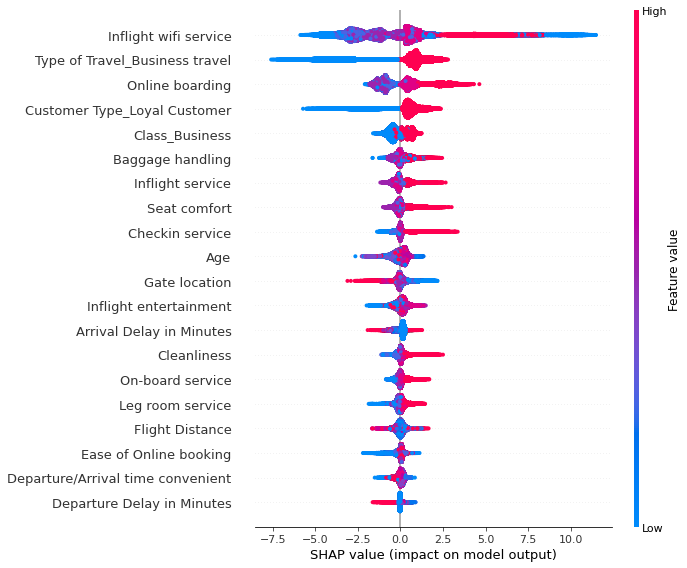

In [156]:
shap.summary_plot(shap_values, X_input)

Видим несколько сранностей
На удовлетворенности положительно сказываются:
1. Отсутствие wi-fi
2. Низкие оценки Gate Location
Вероятно, оказалось, что клиенты из этих пунктов, очень довольны чем-то другим

В остальном, все логично: высокая оценка сервисов положительно сказывается на удовлетворенности, проблемные клиенты - недовольны, те кто летели бизнес классом - довольны, большая задержка вылета плохо сказывается на удовлетворенности

Что интересно, те кто летеют по делам, более удовлетворенны

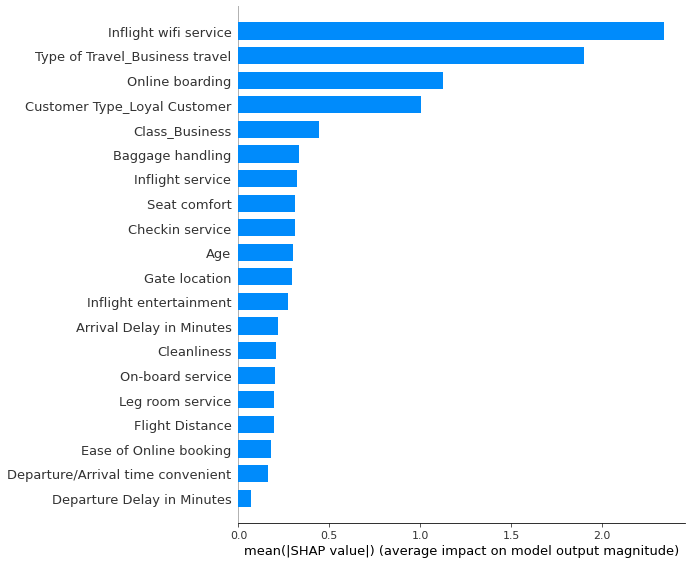

In [158]:
shap.summary_plot(shap_values, X_input, plot_type="bar")

In [160]:
shap.force_plot(explainer.expected_value, shap_values[0,:], X_input.iloc[0,:])

В данном случае на модель повлияло:
    В сторону отнесения к классу 1 (удвл): факт, того, что клиент лоялен
    В сторону отнесения к классу 0 (неудвл): путешествие по делам, средняя оценка wifi, средняя оценка online boarding, возраст ниже среднего, факт того, что клиент летел не бизнес классом 

In [166]:
shap.force_plot(explainer.expected_value, shap_values[1,:], X_input.iloc[1,:])

В данном случае на модель повлияло:
    В сторону отнесения к классу 1 (удвл): факт, того, что клиент летел по делам
    В сторону отнесения к классу 0 (неудвл): проблемный клиент, средняя оценка wifi, средняя оценка online boarding, возраст ниже среднего, низкая оценка onboarding

In [165]:
shap.force_plot(explainer.expected_value, shap_values[50,:], X_input.iloc[50,:])

В данном случае на модель повлияло:
    В сторону отнесения к классу 1 (удвл): факт, того, что клиент летел по делам, лояльный клиент
    В сторону отнесения к классу 0 (неудвл): низкая оценка wifi, возраст ниже среднего, расстояние, задержка прибытия